In [1]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import sys
sys.path.append('../')
import util

In [3]:
TRAIN_FILE = '../data/tomato_samples_small.csv'
VAL_FILE = '../data/tomato_val_dataset.csv'

data = pd.read_csv(TRAIN_FILE, index_col=0)
val_data = pd.read_csv(VAL_FILE, index_col=0)

data

,Overall Liking,Texture liking,Sweetness,Sourness,Salty,Umami,Tomato Flavor Intenstity,glucose,fructose,Soluble solids,...,citric:malic,3-methyl-1-pentanol,2-ethylfuran,isopentyl acetate,cis-3-hexenyl acetate,benzothiazole,benzyl alcohol,citric acid,3-methyl-2-butenal,p-anisaldehyde
0,0.338117,0.340548,0.255690,0.179890,0.128725,0.126539,0.334159,2.295488,1.922709,2.609377,...,2.525383,1.004298,-0.955278,-0.553271,1.215329,0.406991,-0.317549,0.925334,-0.033387,0.608113
1,0.338558,0.341992,0.252528,0.181905,0.130022,0.130761,0.334679,2.289785,1.919508,2.578578,...,2.529219,1.112119,0.359303,-0.553271,1.187403,0.109232,0.152748,0.961596,-0.040644,0.294032
2,0.337087,0.340449,0.254016,0.180934,0.128220,0.129726,0.335890,2.289473,1.922699,2.573799,...,2.523873,1.172092,0.108147,-0.553271,1.213707,-0.001868,0.730046,0.968616,0.070380,0.206275
3,0.335989,0.340927,0.252928,0.179948,0.128490,0.128809,0.333764,2.292482,1.930334,2.548622,...,2.526806,1.106673,0.079866,-0.553271,1.299086,-0.474686,-0.022868,0.907907,-0.013365,-0.513916
4,0.337569,0.341524,0.255614,0.182741,0.129441,0.129830,0.334955,2.304824,1.923364,2.592205,...,2.523320,1.443889,-0.118773,-0.553271,1.268597,0.442448,-0.497099,0.927376,0.041410,-0.305158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,0.038452,0.015696,0.135181,0.084584,0.084834,0.096233,0.192040,-1.276013,-1.679005,-0.150519,...,-0.982699,-0.397338,-1.002327,-0.221668,-2.125245,0.144334,0.169158,-1.035213,-0.157703,1.396681
786,0.026240,0.024049,0.135422,0.090068,0.081171,0.095336,0.191894,-1.270116,-1.682095,-0.108075,...,-1.041210,-0.737587,-0.640720,-2.743479,-0.806120,0.506204,0.943026,-0.896349,-0.130640,-0.173906
787,0.029236,0.000000,0.134633,0.091357,0.082960,0.095025,0.189886,-1.294581,-1.686842,-0.063301,...,-1.039454,0.127056,0.661783,0.241626,-1.405112,-1.141838,0.499814,-0.966758,-0.470647,0.732512
788,0.037208,0.037641,0.133516,0.088080,0.081696,0.096633,0.192062,-1.287375,-1.678820,-0.082891,...,-1.039156,0.369953,-2.062269,1.195457,-1.379818,-0.401819,0.473431,-0.982592,-0.168658,1.120090


In [4]:
assert len(data) // len(val_data) == 10

In [5]:
NUM_LABEL_COLS = 7
FEATURE_COLS = data.columns[NUM_LABEL_COLS:]
LABEL_COLS = data.columns[[0]]
print(FEATURE_COLS)
print(LABEL_COLS)

train_X = data[FEATURE_COLS].values
train_y = data[LABEL_COLS].values
val_X = val_data[FEATURE_COLS].values
val_y = val_data[LABEL_COLS].values

train_X.shape, train_y.shape, val_X.shape, val_y.shape

Index(['glucose', 'fructose', 'Soluble solids', '1-penten-3-one',
       'isovaleronitrile', 'trans-2-pentenal', 'trans-2-heptenal',
       'trans-3-hexen-1-ol', '6-methyl-5-hepten-2-ol', 'nonyl aldehyde',
       'cis-4-decenal', 'sugar:acid', 'isovaleraldehyde', '3-methyl-1-butanol',
       'methional', '2,5-dimethyl-4-hydroxy-3(2H)-furanone', '3-pentanone',
       '1-pentanol', 'benzyl cyanide', 'isovaleric acid', '2-isobutylthiazole',
       '1-nitro-3-methylbutane', 'benzaldehyde', '6-methyl-5-hepten-2-one',
       'b-ionone', 'b-cyclocitral', 'geranial', 'phenylacetaldehyde',
       'eugenol', 'geranylacetone', '2-phenyl ethanol', 'neral',
       'salicylaldehyde', 'isobutyl acetate', 'butyl acetate',
       'cis-3-hexen-1-ol', '1-nitro-2-phenylethane', '1-penten-3-ol',
       '2-methylbutyl acetate', 'heptaldehyde', 'trans,trans-2,4-decadienal',
       'malic acid', '2-methylbutanal', '4-carene', 'hexyl alcohol',
       'guaiacol', 'propyl acetate', 'hexanal', 'cis-2-penten-1-ol'

((790, 70), (790, 1), (79, 70), (79, 1))

In [6]:
FOLDS = 3
NUM_SAMPLE_TYPES = len(val_data)
NUM_SAMPLES_PER_TYPE = len(data) // NUM_SAMPLE_TYPES

fold_nums = list(range(FOLDS))
[num*NUM_SAMPLE_TYPES for num in fold_nums]
[(num+1)*NUM_SAMPLE_TYPES for num in fold_nums]


val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
train_indices
# print(FOLD_INDICES)

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 220, 221, 222,
        223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
        249, 250, 251, 252, 253, 254, 255, 256, 257

In [7]:
[np.sort(val_i) for val_i in val_indices]

[array([ 4,  5,  6, 10, 13, 14, 15, 21, 26, 29, 31, 32, 37, 40, 42, 44, 49,
        56, 57, 58, 61, 64, 66, 68, 71, 72, 77]),
 array([ 0,  3,  8, 16, 17, 18, 19, 20, 22, 23, 24, 27, 28, 30, 36, 39, 41,
        46, 47, 48, 54, 59, 60, 63, 65, 78]),
 array([ 1,  2,  7,  9, 11, 12, 25, 33, 34, 35, 38, 43, 45, 50, 51, 52, 53,
        55, 62, 67, 69, 70, 73, 74, 75, 76])]

In [8]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [733]:
import torch.nn.functional as F

class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, scalar=1, power=1):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.power = power
        self.scalar = scalar

    def forward(self, inputs, targets):
        distances = (torch.abs(inputs.argmax(axis=1) - targets)*self.scalar)**self.power

        loss = F.cross_entropy(inputs, targets, reduction='none') * distances
        return loss.mean()

<h1> Hyperbolic </h1>

In [761]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, regr_output_size, layer_size, num_hidden_layers, manifold, class_output_size=None):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_regr_out = hnn.HLinear(layer_size, regr_output_size, manifold=manifold)
        if class_output_size:
            self.fc_class_out = hnn.HLinear(layer_size, class_output_size, manifold=manifold)
        else:
            self.fc_class_out = lambda _: -1

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)

        regr_out = self.fc_regr_out(x)

        if self.training:
            class_out = self.fc_class_out(x).tensor
            return regr_out, class_out

        return regr_out


# Define training function
def hyp_train_model(model, train_loader, regr_criterion, optimizer, manifold, device, class_criterion=None, class_bin_edges=[]):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        regr_outputs, class_outputs = model(manifold_inputs)

        loss = regr_criterion(regr_outputs.tensor, targets)

        if class_criterion and class_bin_edges is not None:
            class_targets = (torch.Tensor(np.digitize(targets, class_bin_edges)) - 1).clip(0,len(class_bin_edges)-2).to(torch.long).flatten()
            class_loss = class_criterion(class_outputs, class_targets)

            loss += class_loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [768]:
param_grid = {
    'class_loss_bins': [2,3,4,5,6,7,8],
    'class_loss_scalar': [0.1,0.2,0.4,0.8,1.6],
    'class_loss_power': [0.1,0.2,0.4,0.8,1.6],
    'model_type': ['hyp'],
    'num_hidden_layers': [4],
    'layer_size': [64],
    'lr': [0.02],
    'weight_decay': [0.004],
    'batch_size': [1024],
    'epochs': [100],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

175

In [769]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    class_loss_bins, class_loss_scalar, class_loss_power, model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
    class_bin_edges = np.histogram_bin_edges(train_y, class_loss_bins)

    for fold, (fold_train_indices, fold_val_indices) in enumerate(zip(train_indices, val_indices)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        fold_val_X   = val_X[fold_val_indices]
        fold_val_y   = val_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        manifold = PoincareBall(c=Curvature(curvature))

        model = HYP_MLP(input_size=len(FEATURE_COLS),
                        regr_output_size=len(LABEL_COLS),
                        layer_size=layer_size,
                        num_hidden_layers=num_hidden_layers,
                        manifold=manifold,
                        class_output_size=class_loss_bins).to(device)

        regr_criterion = nn.MSELoss()
        # class_criterion = nn.CrossEntropyLoss()
        class_criterion = OrdinalCrossEntropyLoss(scalar=class_loss_scalar,power=class_loss_power)

        optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []}, 'mae': {'train': [], 'val': []}}

        for epoch in range(epochs):
            eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, regr_criterion, optimizer, manifold, device,
                                                               class_criterion, class_bin_edges))
            # eval_stats['loss']['val'].append(util.h_evaluate_loss(model, val_loader, criterion, manifold, device))

            # eval_stats['mae']['train'].append(util.h_evaluate_mae(model, train_loader, manifold, device))
            eval_stats['mae']['val'].append(util.h_evaluate_mae(model, val_loader, manifold, device))

        print(eval_stats['mae']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('class_loss_bins', 2) ('class_loss_scalar', 0.1) ('class_loss_power', 0.1) ('model_type', 'hyp') ('num_hidden_layers', 4) ('layer_size', 64) ('lr', 0.02) ('weight_decay', 0.004) ('batch_size', 1024) ('epochs', 100) ('curvature', -1)
Fold 0
[1.0732657, 0.65573716, 0.29852504, 0.22382659, 0.2219175, 0.23939565, 0.22927609, 0.20601626, 0.18192014, 0.16191216, 0.14603826, 0.13649571, 0.12983896, 0.12418133, 0.11835801, 0.11259164, 0.10642647, 0.099855565, 0.09332239, 0.08707473, 0.08115805, 0.07569753, 0.07062653, 0.06574756, 0.06240088, 0.05980453, 0.057830833, 0.055841718, 0.05387744, 0.051983286, 0.05076417, 0.049290422, 0.04785544, 0.047111426, 0.047111608, 0.0475789, 0.048325464, 0.049261738, 0.049970537, 0.050296023, 0.050173476, 0.04979951, 0.049398232, 0.048920132, 0.048242092, 0.04751632, 0.04696395, 0.046470538, 0.046039272, 0.045652892, 0.045387845, 0.045468584, 0.045675244, 0.04590819, 0.046149056, 0.046380445, 0.046635937, 0.046939485, 0.04724133, 0.

In [770]:
values = np.array([s['mae']['val'] for s in param_eval_stats])
values = values.reshape(values.shape[0]//3,3,values.shape[-1])

In [771]:
values.shape

(175, 3, 100)

In [782]:
print(values.mean(axis=1)[:,-1].argsort()[:10])

[29  6  4  1 13  9 17 12 10  7]


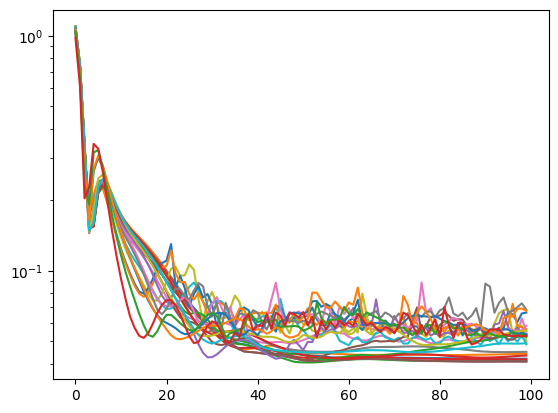

In [767]:
import matplotlib.pyplot as plt

plt.plot(values.mean(axis=1).T)
plt.yscale('log')
plt.show()
